In [62]:
import os
import requests
import torch
from torch import nn
import torchvision
from torchvision import transforms
from pathlib import Path
from typing import List
import matplotlib.pyplot as plt


In [63]:
# Creating a function to predicting on a single image

def predict_image(model: torch.Tensor,
                 class_names: List[str],
                 device: torch.device,
                 url: str,  image_title: str = None,
                 transform: torch.utils.data = None):
    """Downloading the image and predicting on the image using specific model."""
    # Get/Create path.
    primary_path = Path("data/")
    image_predicted_path_images = primary_path / "prediction/images/"
    if image_predicted_path_images.is_dir():
        print(f"{image_predicted_path_images} is already created skipping.... ❌")
    else:
        image_predicted_path_images.mkdir(parents=True, exist_ok=True)
        print(f"{image_predicted_path_images} is created ✅.")

    # Check url if it's blank or not string data type.
    if url == '' or not isinstance(url, str):
        raise Exception("Url isn't found or invalid type, required url ❌.")

    # Check if image_title isn't provided, if not then extract url
    # name from url link.
    if image_title is None:
        image_title = str(url.split("/")[-1]).split(".")[0]

    image_path = primary_path / f"prediction/images/{image_title}.png"

    # Download and save image in the above directory.
    with open(image_path, 'wb') as f:
        response = requests.get(str(url))
        print(f"{image_title} is downloading... ⏳")
        f.write(response.content)
        print(f"{image_title} is downloaded ✅.")

    # Decode the image to convert image into tensor.
    target_image = torchvision.io.decode_image(input=image_path).type(torch.float32) / 255

    # Transform the image if needed(optional).
    if transform is not None:
        target_image = transform(target_image)

    # Adding model to device CPU/GPU(CUDA).
    model.to(device)
    
    # Switching model to evaluation mode (Disabling gradient
    # tracking and some others etc).
    model.eval()

    # Making a prediction on model(output is logits).
    with torch.inference_mode():
        # adding batch to image torch.Size([3, 224, 224])
        # to torch.Size([1, 3, 224, 224]) very important
        # when using mini batches training.
        target_image = target_image.unsqueeze(dim=0)
        # predict the image using model.
        target_image_pred = model(target_image.to(device))

    # Convert to logits -> prediction probabilities -> prediction label.
    target_image_pred_label = torch.round(torch.sigmoid(target_image_pred))

    #showing image/plot image in matplotlib
    plt.imshow(target_image.squeeze().permute(1, 2, 0).cpu().numpy())

    # Checking for class names if present or not
    # If present then will be plot class names
    if class_names:
        title = f"Prediction: {class_names[int(target_image_pred_label.cpu())]}"
    else:
        title = f"Prediction: {int(target_image_pred_label)}"
    plt.title(title)
    plt.axis(False)


In [64]:
# Create a convolutional neural network
class TinyVGG(nn.Module):
  """
    Model architecture that replicates the TinyVGG
    model from CNN explainer website.
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # Create a conv layer
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),

        nn.ReLU(),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),

        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel size.
    )

    self.conv_block_2 = nn.Sequential(
        # Create a conv layer
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),

        nn.ReLU(),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),

        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*53*53, # There is a trick to calculating this... just print out privious layer shape
        out_features=output_shape)

    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

In [65]:
# Create a convolutional neural network
class TinyVGGv2(nn.Module):
  """
    Model architecture that replicates the TinyVGG
    model from CNN explainer website.
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # Create a conv layer
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        
        nn.BatchNorm2d(hidden_units),

        nn.ReLU(),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),

        nn.BatchNorm2d(hidden_units),

        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel size.
    )

    self.conv_block_2 = nn.Sequential(
        # Create a conv layer
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),

        nn.BatchNorm2d(hidden_units),

        nn.ReLU(),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),

        nn.BatchNorm2d(hidden_units),

        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_3 = nn.Sequential(
        # Create a conv layer
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),

        nn.BatchNorm2d(hidden_units),

        nn.ReLU(),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),

        nn.BatchNorm2d(hidden_units),

        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_4 = nn.Sequential(
        # Create a conv layer
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),

        nn.BatchNorm2d(hidden_units),

        nn.ReLU(),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),

        nn.BatchNorm2d(hidden_units),

        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_5 = nn.Sequential(
        # Create a conv layer
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),

        nn.BatchNorm2d(hidden_units),

        nn.ReLU(),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),

        nn.BatchNorm2d(hidden_units),

        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=hidden_units*7*7, # There is a trick to calculating this... just print out privious layer shape
        out_features=output_shape)

    )

  def forward(self, x):
    return self.classifier(self.conv_block_5(self.conv_block_4(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))))) # benefits from operator fusion

In [66]:
# # Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [67]:

# Get saved model paths
MODEL_PATH = Path("models/cat_dog_classification/")

# 2. model names
MODEL_NAME_0 = "00_pytorch_cat_and_dog_classification_vision_model_0.pth"
MODEL_NAME_2 = "02_pytorch_cat_and_dog_classification_vision_model_2.pth"
MODEL_NAME_3 = "03_pytorch_cat_and_dog_classification_vision_model_3.pth"

# model paths
MODEL_SAVE_PATH_0 = MODEL_PATH / MODEL_NAME_0
MODEL_SAVE_PATH_2 = MODEL_PATH / MODEL_NAME_2
MODEL_SAVE_PATH_3 = MODEL_PATH / MODEL_NAME_3

# instance of models for adding trained weight and biases
loaded_model_0 = TinyVGG(
    input_shape = 3,
    hidden_units = 20,
    output_shape = 1,
)

loaded_model_2 = TinyVGGv2(
    input_shape = 3,
    hidden_units = 20,
    output_shape = 1,
)

loaded_model_3 = TinyVGGv2(
    input_shape = 3,
    hidden_units = 20,
    output_shape = 1,
)

# Load the saved model_0 state dict
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH_0))
loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH_2))
loaded_model_3.load_state_dict(torch.load(MODEL_SAVE_PATH_3))

# Put the loaded model to device
loaded_model_0.to(device)
loaded_model_2.to(device)
loaded_model_3.to(device)

TinyVGGv2(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    

In [68]:
# Write a transform for data augmentation to images

data_transform = transforms.Compose([
    # Resize all images to (224x224)
    transforms.Resize(size=(224, 224)),
])


data\prediction\images is already created skipping.... ❌
Orange-colored-cat-yawns-displaying-teeth is downloading... ⏳
Orange-colored-cat-yawns-displaying-teeth is downloaded ✅.


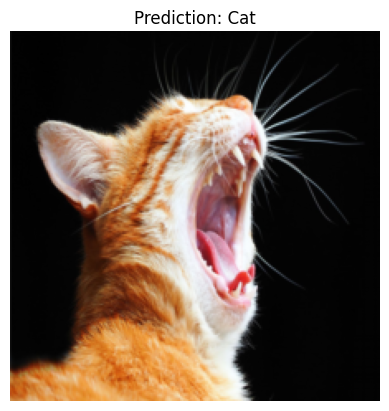

In [69]:

predict_image(model = loaded_model_0,
                 class_names = ['Cat', 'Dog'],
                 device = device,
                 url = "https://cdn.britannica.com/70/234870-050-D4D024BB/Orange-colored-cat-yawns-displaying-teeth.jpg",
                 image_title = None,
                 transform = data_transform)

data\prediction\images is already created skipping.... ❌
Orange-colored-cat-yawns-displaying-teeth is downloading... ⏳
Orange-colored-cat-yawns-displaying-teeth is downloaded ✅.


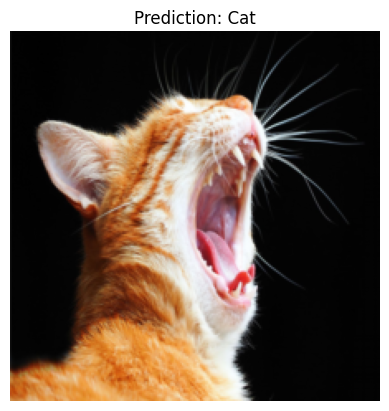

In [70]:
predict_image(model = loaded_model_2,
                 class_names = ['Cat', 'Dog'],
                 device = device,
                 url = "https://cdn.britannica.com/70/234870-050-D4D024BB/Orange-colored-cat-yawns-displaying-teeth.jpg",
                 image_title = None,
                 transform = data_transform)

data\prediction\images is already created skipping.... ❌
Orange-colored-cat-yawns-displaying-teeth is downloading... ⏳
Orange-colored-cat-yawns-displaying-teeth is downloaded ✅.


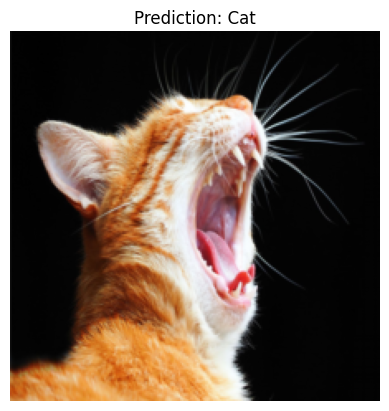

In [71]:
predict_image(model = loaded_model_3,
                 class_names = ['Cat', 'Dog'],
                 device = device,
                 url = "https://cdn.britannica.com/70/234870-050-D4D024BB/Orange-colored-cat-yawns-displaying-teeth.jpg",
                 image_title = None,
                 transform = data_transform)

data\prediction\images is already created skipping.... ❌
3408 is downloading... ⏳
3408 is downloaded ✅.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010582509..1.0000004].


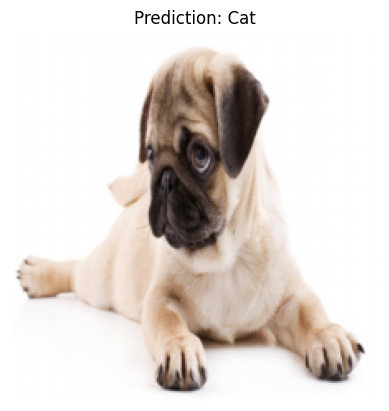

In [72]:

predict_image(model = loaded_model_0,
                 class_names = ['Cat', 'Dog'],
                 device = device,
                 url = "https://i.guim.co.uk/img/media/fe1e34da640c5c56ed16f76ce6f994fa9343d09d/0_174_3408_2046/master/3408.jpg?width=1200&quality=85&auto=format&fit=max&s=1aaf31e276b20b5d12d4bee49c5a99e2",
                 image_title = None,
                 transform = data_transform)

data\prediction\images is already created skipping.... ❌
3408 is downloading... ⏳
3408 is downloaded ✅.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010582509..1.0000004].


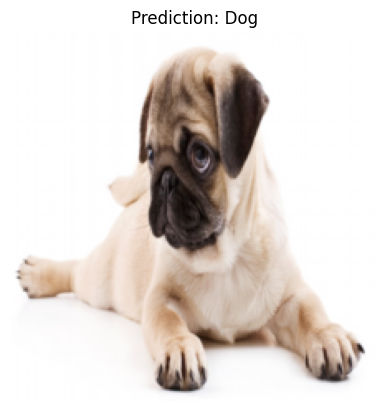

In [73]:
predict_image(model = loaded_model_2,
                 class_names = ['Cat', 'Dog'],
                 device = device,
                 url = "https://i.guim.co.uk/img/media/fe1e34da640c5c56ed16f76ce6f994fa9343d09d/0_174_3408_2046/master/3408.jpg?width=1200&quality=85&auto=format&fit=max&s=1aaf31e276b20b5d12d4bee49c5a99e2",
                 image_title = None,
                 transform = data_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010582509..1.0000004].


data\prediction\images is already created skipping.... ❌
3408 is downloading... ⏳
3408 is downloaded ✅.


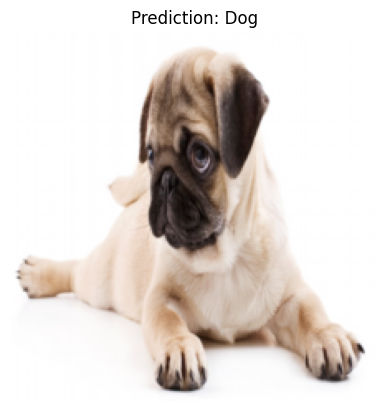

In [74]:
predict_image(model = loaded_model_3,
                 class_names = ['Cat', 'Dog'],
                 device = device,
                 url = "https://i.guim.co.uk/img/media/fe1e34da640c5c56ed16f76ce6f994fa9343d09d/0_174_3408_2046/master/3408.jpg?width=1200&quality=85&auto=format&fit=max&s=1aaf31e276b20b5d12d4bee49c5a99e2",
                 image_title = None,
                 transform = data_transform)

data\prediction\images is already created skipping.... ❌
small-dog-breeds-yorkshire-terrier-1583349591 is downloading... ⏳
small-dog-breeds-yorkshire-terrier-1583349591 is downloaded ✅.


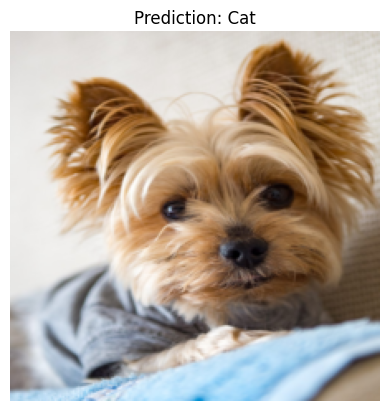

In [75]:

predict_image(model = loaded_model_0,
                 class_names = ['Cat', 'Dog'],
                 device = device,
                 url = "https://hips.hearstapps.com/hmg-prod/images/small-dog-breeds-yorkshire-terrier-1583349591.jpg?crop=0.641xw:1.00xh;0.243xw,0&resize=980:*",
                 image_title = None,
                 transform = data_transform)

data\prediction\images is already created skipping.... ❌
small-dog-breeds-yorkshire-terrier-1583349591 is downloading... ⏳
small-dog-breeds-yorkshire-terrier-1583349591 is downloaded ✅.


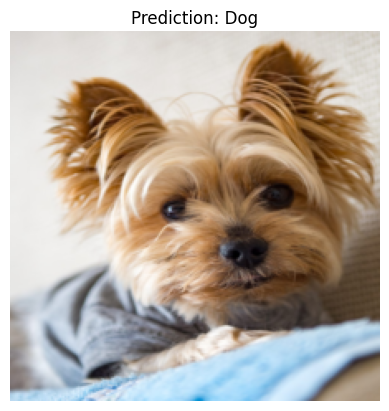

In [76]:

predict_image(model = loaded_model_2,
                 class_names = ['Cat', 'Dog'],
                 device = device,
                 url = "https://hips.hearstapps.com/hmg-prod/images/small-dog-breeds-yorkshire-terrier-1583349591.jpg?crop=0.641xw:1.00xh;0.243xw,0&resize=980:*",
                 image_title = None,
                 transform = data_transform)

data\prediction\images is already created skipping.... ❌
small-dog-breeds-yorkshire-terrier-1583349591 is downloading... ⏳
small-dog-breeds-yorkshire-terrier-1583349591 is downloaded ✅.


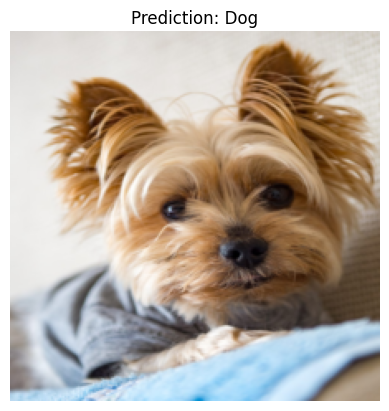

In [77]:

predict_image(model = loaded_model_3,
                 class_names = ['Cat', 'Dog'],
                 device = device,
                 url = "https://hips.hearstapps.com/hmg-prod/images/small-dog-breeds-yorkshire-terrier-1583349591.jpg?crop=0.641xw:1.00xh;0.243xw,0&resize=980:*",
                 image_title = None,
                 transform = data_transform)

data\prediction\images is already created skipping.... ❌
shih-tzu-portrait is downloading... ⏳
shih-tzu-portrait is downloaded ✅.


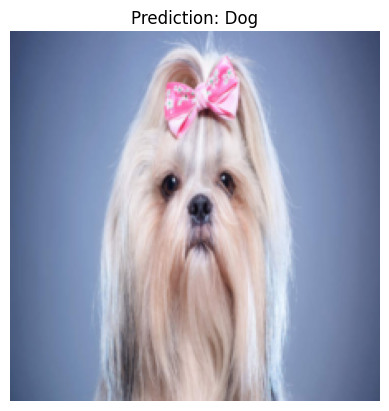

In [78]:
predict_image(model = loaded_model_0,
                 class_names = ['Cat', 'Dog'],
                 device = device,
                 url = "https://www.nylabone.com/-/media/project/oneweb/nylabone/images/dog101/activities-fun/10-great-small-dog-breeds/shih-tzu-portrait.jpg",
                 image_title = None,
                 transform = data_transform)

data\prediction\images is already created skipping.... ❌
shih-tzu-portrait is downloading... ⏳
shih-tzu-portrait is downloaded ✅.


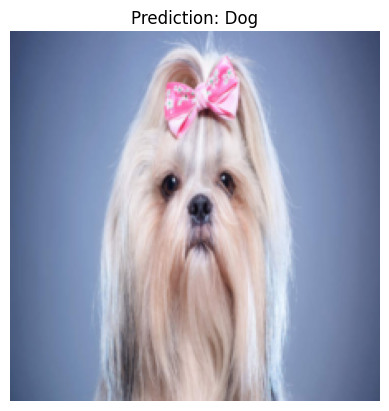

In [79]:
predict_image(model = loaded_model_2,
                 class_names = ['Cat', 'Dog'],
                 device = device,
                 url = "https://www.nylabone.com/-/media/project/oneweb/nylabone/images/dog101/activities-fun/10-great-small-dog-breeds/shih-tzu-portrait.jpg",
                 image_title = None,
                 transform = data_transform)

data\prediction\images is already created skipping.... ❌
shih-tzu-portrait is downloading... ⏳
shih-tzu-portrait is downloaded ✅.


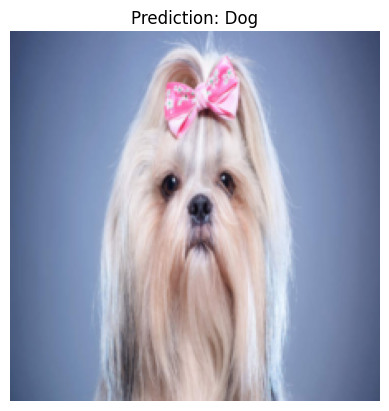

In [80]:
predict_image(model = loaded_model_3,
                 class_names = ['Cat', 'Dog'],
                 device = device,
                 url = "https://www.nylabone.com/-/media/project/oneweb/nylabone/images/dog101/activities-fun/10-great-small-dog-breeds/shih-tzu-portrait.jpg",
                 image_title = None,
                 transform = data_transform)